## 2023 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [51]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter
from tqdm import tqdm

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

# If you fetch_matches best to set reset=True or you may miss some events.
fetch_matches = False
reset = True
year = 2023

if fetch_matches:
    from fetchMatches import fetch_all_matches
    # This will save to matches_{year}.pkl
    fetch_all_matches(year, reset=reset)


In [52]:
# load all the matches
filename = f'matches_{year}.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)
    
# Load the aggregates
with open(f'teamStats_{year}.pkl','rb') as f:
    teamAggregates = pickle.load(f)
    
    
# Load the model
model_fn = f'model_{year}_forest.pkl'
with open(model_fn, 'rb') as f:
    vectorizer, model = pickle.load(f)

In [53]:
event = '2023wasam'
teams = [m.key for m in matches['event_teams'][event]]
teams

['frc1294',
 'frc1899',
 'frc1983',
 'frc2097',
 'frc2412',
 'frc2903',
 'frc2910',
 'frc2928',
 'frc2976',
 'frc3070',
 'frc360',
 'frc3681',
 'frc3876',
 'frc4173',
 'frc4180',
 'frc4450',
 'frc4512',
 'frc4682',
 'frc488',
 'frc4911',
 'frc492',
 'frc5827',
 'frc5937',
 'frc5941',
 'frc7461',
 'frc8032',
 'frc8051',
 'frc8248',
 'frc9023',
 'frc9036',
 'frc948',
 'frc949']

Now we have statistics for every team.  We can use this to generate features for every match.

In [54]:
from tqdm import tqdm
from featurization import featurizeAlliances
from itertools import combinations
features = []

self_alliances = [[t]*3 for t in teams]
alliances = []

for red,blue in combinations(self_alliances, 2):        
        f = featurizeAlliances(teamAggregates, red, blue)
        features.append(f)
        alliances.append([red,blue])
    
print(f"Running {len(features)} predictions")
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (r,b), score in zip(alliances, scores):     
    r=r[0]
    b=b[0]
    if r not in results:
        results[r] = 0
    results[r] += score[1]
    if b not in results:
        results[b] = 0
    results[b] += 1-score[1]

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(f'{r}\t{results[r]*100/len(self_alliances):0.2f}')


Running 496 predictions
frc2910	77.73
frc1983	73.11
frc7461	70.86
frc488	69.22
frc492	68.05
frc2412	64.61
frc4911	63.00
frc2976	62.67
frc4173	59.65
frc9023	54.00
frc360	52.20
frc3876	47.76
frc9036	45.85
frc1899	45.57
frc5937	45.39
frc4512	44.24
frc4450	44.19
frc5941	43.06
frc948	42.40
frc3070	41.70
frc4180	40.35
frc2928	40.14
frc4682	39.79
frc5827	38.55
frc8032	37.47
frc8051	37.09
frc1294	35.16
frc2903	34.75
frc8248	34.23
frc949	33.27
frc3681	33.11
frc2097	30.85


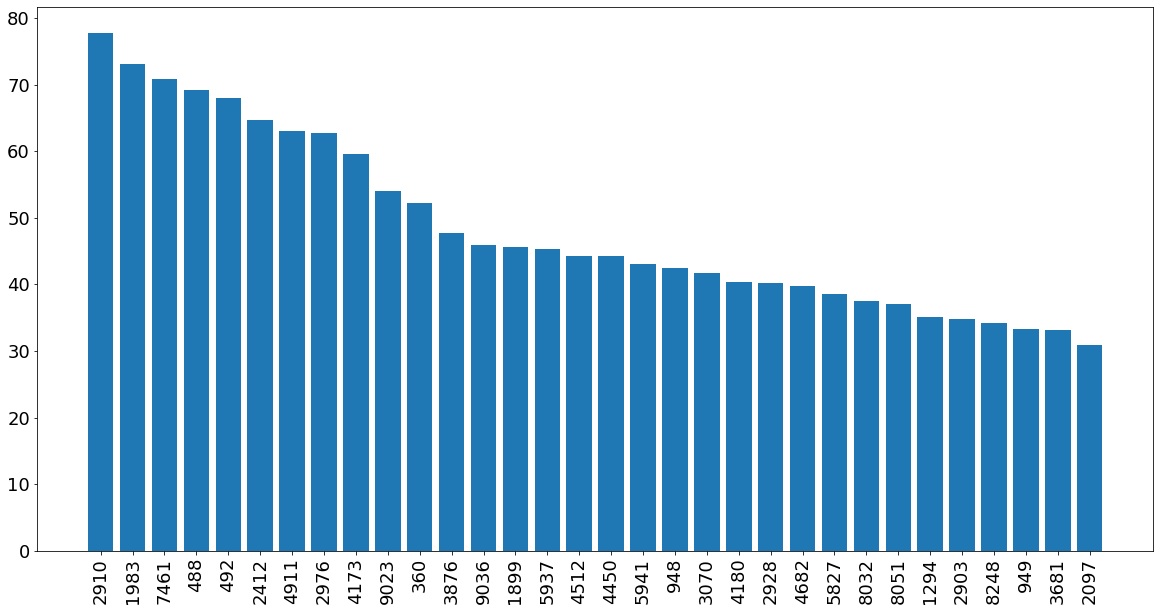

In [55]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
fig,ax = plt.subplots()
xvals = list(sorted(results, key=lambda x: results[x], reverse=True))
xlab = [x[3:] for x in xvals]
ax.bar(xlab,[results[r]*100/len(self_alliances) for r in xvals])
ax.tick_params(axis='x', labelsize=18, rotation=90)
ax.tick_params(axis='y', labelsize=18)